In [1]:
!pip -q install opencv-python

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import files
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))

Saving pepper.jpg to pepper.jpg
Uploaded: ['pepper.jpg']


In [5]:
def show(img_bgr, title="image", size=6):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size, size))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_gray(img_gray, title="mask", size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(img_gray, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

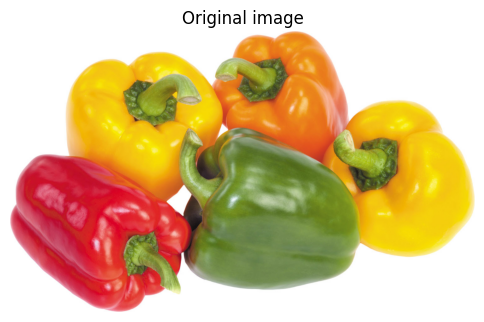

In [6]:
IMG_PATH = "pepper.jpg"   # <-- change if your file name differs

img = cv2.imread(IMG_PATH)
if img is None:
    raise FileNotFoundError(f"Could not read {IMG_PATH}. Check the filename in Colab Files.")
show(img, "Original image")

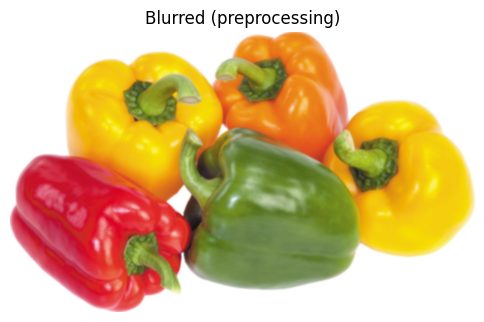

In [7]:
# resize for consistent processing
TARGET_W = 800
h, w = img.shape[:2]
if w > TARGET_W:
    scale = TARGET_W / w
    img = cv2.resize(img, (int(w*scale), int(h*scale)))

blur = cv2.GaussianBlur(img, (5,5), 0)
show(blur, "Blurred (preprocessing)")

In [8]:
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

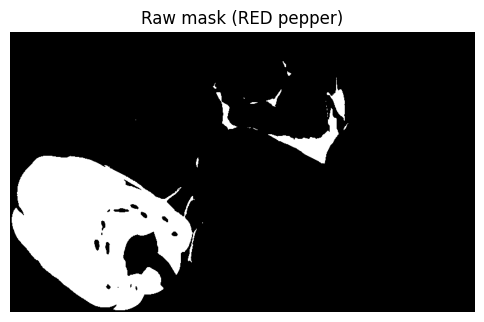

In [9]:
# RED has two HSV ranges (wrap-around)
lower1 = np.array([0, 120, 70]);   upper1 = np.array([10, 255, 255])
lower2 = np.array([170,120, 70]);  upper2 = np.array([180,255,255])

mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
mask = cv2.bitwise_or(mask1, mask2)

show_gray(mask, "Raw mask (RED pepper)")

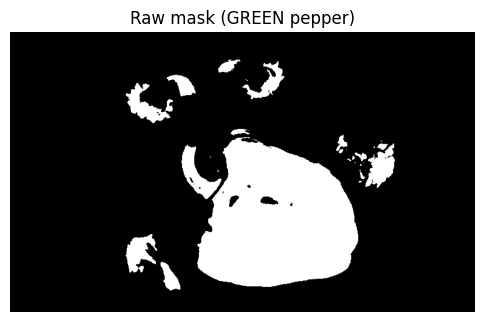

In [10]:
# GREEN range (may need slight tuning depending on lighting)
lower = np.array([35, 60, 40])
upper = np.array([85, 255, 255])

mask = cv2.inRange(hsv, lower, upper)
show_gray(mask, "Raw mask (GREEN pepper)")

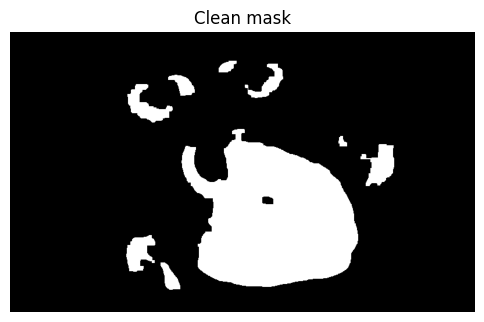

In [11]:
kernel = np.ones((5,5), np.uint8)

mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel, iterations=2)

show_gray(mask_clean, "Clean mask")

In [12]:
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours found:", len(contours))

Contours found: 9


Detected peppers (kept contours): 6


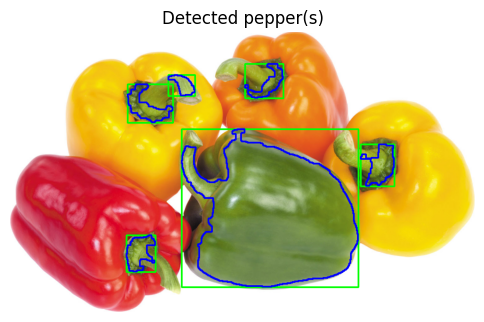

In [13]:
out = img.copy()

kept = 0
for c in contours:
    area = cv2.contourArea(c)
    if area < 800:   # <-- increase if too many tiny detections
        continue

    kept += 1
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(out, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.drawContours(out, [c], -1, (255,0,0), 2)

print("Detected peppers (kept contours):", kept)
show(out, "Detected pepper(s)")

In [14]:
pepper_pixels = np.sum(mask_clean > 0)
total_pixels  = mask_clean.size
ratio = pepper_pixels / total_pixels

print(f"Pepper pixel ratio: {ratio:.4f}  (~{ratio*100:.2f}%)")

Pepper pixel ratio: 0.1681  (~16.81%)


In [15]:
cv2.imwrite("mask_clean.png", mask_clean)
cv2.imwrite("pepper_detected.png", out)

print("Saved: mask_clean.png, pepper_detected.png")

Saved: mask_clean.png, pepper_detected.png


In [16]:
files.download("mask_clean.png")
files.download("pepper_detected.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>